## Setup

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
import numpy as np

import os
import math

# Main slim library
from tensorflow.contrib import slim

Populating the interactive namespace from numpy and matplotlib


C:\Users\orrav\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


## Display Bird Images

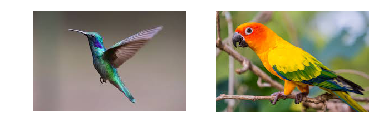

In [2]:
bird0 = mpimg.imread(os.path.join('..', 'Data', 'birds', 'bird_0.jpg'))
bird1 = mpimg.imread(os.path.join('..', 'Data', 'birds', 'bird_1.jpg'))
plt.figure()
plt.subplot(121); plt.imshow(bird0); plt.axis('off')

plt.subplot(122); plt.imshow(bird1); plt.axis('off')
plt.show()

## Building Graph and Predictions
Since a list of images may contain images in different sizes, we will build the graph only once and feed it multiple times.
That way, we are reusing the graph in each prediction instead of resetting and building it all over again.

In [3]:
# from slim library
import vgg_preprocessing
import imagenet
import vgg

# global
image_size  = vgg.vgg_16.default_image_size

def build_graph():    
    image_placeholder = tf.placeholder(tf.float32, shape=[None, None, 3])
    processed_image = vgg_preprocessing.preprocess_image(image_placeholder, image_size, image_size, is_training=False)
    processed_images  = tf.expand_dims(processed_image, 0)
    with slim.arg_scope(vgg.vgg_arg_scope()):
        logits, end_points = vgg.vgg_16(processed_images, num_classes=1000, is_training=False)
    probabilities = tf.nn.softmax(logits)
    return probabilities, image_placeholder, end_points

def init_variables():
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join('..', 'Data', 'vgg_16.ckpt'),
        slim.get_model_variables('vgg_16'))
    return init_fn

def predict(images, probabilities, image_placeholder):
    np_probabilities = sess.run(probabilities, feed_dict={image_placeholder: images})
    return np_probabilities

def showImage(np_image_raw, np_probabilities):
    names = imagenet.create_readable_names_for_imagenet_labels()
    np_probability = np_probabilities[0, :]
    sorted_inds = [j[0] for j in sorted(enumerate(-np_probability), key=lambda x:x[1])]
    
    plt.figure()
    plt.imshow(np_image_raw.astype(np.uint8))
    plt.axis('off')
    plt.show()

    for k in range(5):
            index = sorted_inds[k]
            # Shift the index of a class name by one. 
            print('Probability %0.2f%% => [%s]' % (np_probability[index] * 100, names[index+1]))

INFO:tensorflow:Restoring parameters from ..\Data\vgg_16.ckpt


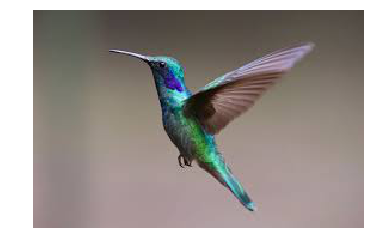

Probability 99.95% => [hummingbird]
Probability 0.04% => [jacamar]
Probability 0.01% => [bee eater]
Probability 0.00% => [black stork, Ciconia nigra]
Probability 0.00% => [red-breasted merganser, Mergus serrator]


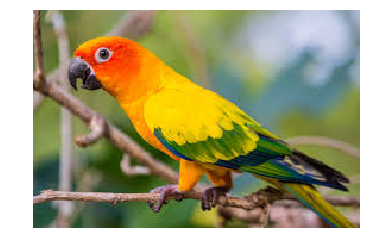

Probability 99.32% => [lorikeet]
Probability 0.46% => [macaw]
Probability 0.05% => [hummingbird]
Probability 0.04% => [bee eater]
Probability 0.04% => [jacamar]


In [4]:
tf.reset_default_graph()
probabilities, image_placeholder, end_points = build_graph()
init_fn = init_variables()
sess = tf.InteractiveSession()
init_fn(sess)
images = [bird0, bird1]
batch_size = len(images)
for i in range(batch_size):
    np_probabilities = predict(images[i], probabilities, image_placeholder)
    showImage(images[i], np_probabilities)

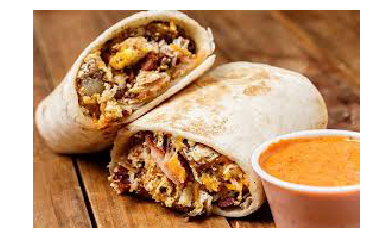

Probability 98.86% => [burrito]
Probability 0.33% => [guacamole]
Probability 0.22% => [potpie]
Probability 0.11% => [plate]
Probability 0.11% => [French loaf]


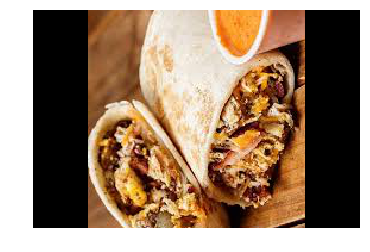

Probability 79.19% => [burrito]
Probability 2.58% => [butternut squash]
Probability 2.38% => [guacamole]
Probability 1.85% => [French loaf]
Probability 1.61% => [pizza, pizza pie]


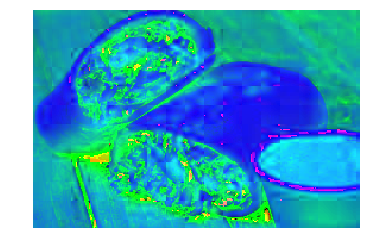

Probability 43.09% => [beaker]
Probability 25.15% => [Petri dish]
Probability 13.18% => [bubble]
Probability 6.58% => [measuring cup]
Probability 3.50% => [oscilloscope, scope, cathode-ray oscilloscope, CRO]


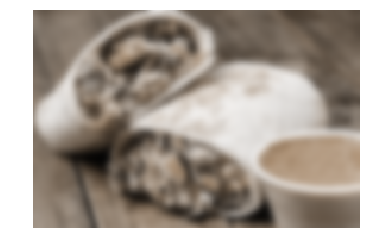

Probability 57.92% => [rock python, rock snake, Python sebae]
Probability 3.34% => [sidewinder, horned rattlesnake, Crotalus cerastes]
Probability 2.74% => [eggnog]
Probability 2.34% => [chambered nautilus, pearly nautilus, nautilus]
Probability 1.91% => [boa constrictor, Constrictor constrictor]


In [7]:
from skimage import transform
from skimage import color
from skimage import filters
    
# image and some transformations
orig_burrito          = mpimg.imread(os.path.join('..', 'Data', 'burrito.jpg'))
g_tform_burrito       = transform.rotate(orig_burrito, angle=90)*255
color_tform_burrito   = color.convert_colorspace(orig_burrito, 'RGB', 'HSV')*255
filtered_burrito      = filters.gaussian(orig_burrito, sigma=3, multichannel=False)*255

burrito_images = [orig_burrito, g_tform_burrito, color_tform_burrito, filtered_burrito]
batch_size = len(burrito_images)
for i in range(batch_size):
    np_probabilities = predict(burrito_images[i], probabilities, image_placeholder, sess)
    showImage(burrito_images[i], np_probabilities)

In [8]:
def plot_conv_weights(weights, indices, images):
    """plots given filters and their responses to a given input.
    Args:
        weights: variable name
        indices: vector of indices smaller than num_filters
        images: list of input images
    """
    w = sess.run(weights)
    num_chosen_filters = len(indices)
            
    # Create sub-plots for each filter.
    fig, axes = plt.subplots(1, num_chosen_filters)

    for i, ax in enumerate(axes.flat):
        if i < num_chosen_filters:
            filter_img = w[:, :, :, indices[i]]
            ax.imshow(filter_img, interpolation='nearest')
        ax.set_xticks([])
        ax.set_yticks([])  
    plt.show() 
        
    # Build graph for filter respones    
    processed_image = vgg_preprocessing.preprocess_image(image_placeholder, image_size, image_size, is_training=False)
    processed_images  = tf.expand_dims(processed_image, 0)
    conv = tf.nn.conv2d(processed_images, w, strides=[1,1,1,1], padding='SAME') 
    
    # Eval and plot responses for each image in images
    batch_size = len(images)
    for j in range(batch_size):    
        res_sess = tf.Session()
        res_sess.run(tf.global_variables_initializer())
        filterResponse = res_sess.run(conv, feed_dict={image_placeholder: images[j]})
        fig, axes = plt.subplots(1, num_chosen_filters)
        for i, ax in enumerate(axes.flat):
            if i < num_chosen_filters:
                filter_res = filterResponse[0, :, :, indices[i]]
                ax.imshow(filter_res, cmap='viridis')
            ax.set_xticks([])
            ax.set_yticks([])
        plt.show() 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


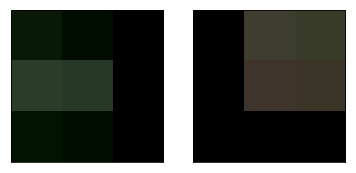

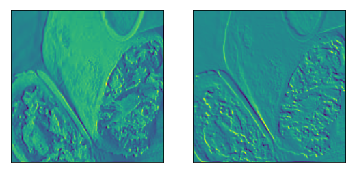

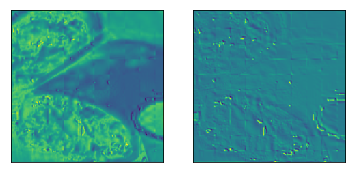

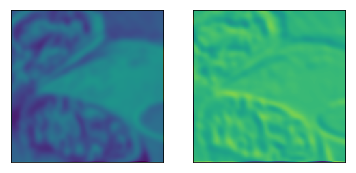

In [9]:
with tf.variable_scope('vgg_16', reuse=True):
    weights = tf.get_variable('conv1/conv1_1/weights')
    indices = [2, 4]
    burrito_transforms = [g_tform_burrito, color_tform_burrito, filtered_burrito]
    plot_conv_weights(weights, indices, burrito_transforms)

In [5]:
features = end_points['vgg_16/fc7']
dog_features_mat = []
cat_features_mat = []
path = os.path.join('..', 'Data')
first = 0
for file in os.listdir(os.path.join(path, 'dogs')):
    dog_img = mpimg.imread(os.path.join(path, 'dogs', file))
    dog_features_vec = sess.run(features, feed_dict={image_placeholder: dog_img})
    dog_features_vec = dog_features_vec[0,0,0,:]
    dog_features_vec = np.expand_dims(dog_features_vec, axis=0)
    if first == 0:
        dog_features_mat = dog_features_vec
        first += 1
    else:
        dog_features_mat = np.append(dog_features_mat, dog_features_vec, axis=0)

first = 0
for file in os.listdir(os.path.join(path, 'cats')):
    cat_img = mpimg.imread(os.path.join(path, 'cats', file))
    cat_features_vec = sess.run(features, feed_dict={image_placeholder: cat_img})
    cat_features_vec = cat_features_vec[0,0,0,:]
    cat_features_vec = np.expand_dims(cat_features_vec, axis=0)
    if first == 0:
        cat_features_mat = cat_features_vec
        first += 1
    else:
        cat_features_mat = np.append(cat_features_mat, cat_features_vec, axis=0)

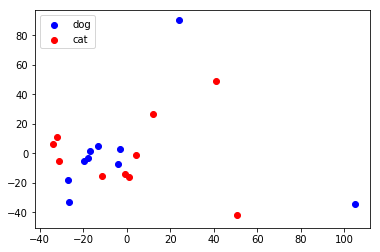

In [50]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

fig = plt.figure()
ax = fig.add_subplot(111)

dog_features_reduced = PCA(n_components=2).fit_transform(dog_features_mat)
cat_features_reduced = PCA(n_components=2).fit_transform(cat_features_mat)
ax.scatter(dog_features_reduced[:,0], dog_features_reduced[:,1], color='b', label='dog')
ax.scatter(cat_features_reduced[:,0], cat_features_reduced[:,1], color='r', label='cat')
plt.legend(loc='upper left')
plt.show()

In [71]:
def extract_features(layer, input_image, image_placeholder):
    features = sess.run(layer, feed_dict={image_placeholder: input_image})
    features = features[0,0,0,:]
    return features

def min_L1_dist(test_features, train_features):
    num_samp = train_features.shape[0]
    dist_vec = np.sum(np.abs(train_mat - np.tile(test_features, (num_samp, 1))), 1)
    return np.min(dist_vec), np.argmin(dist_vec)



test_cat = mpimg.imread(os.path.join('..', 'Data', 'cat_web.jpeg'))
test_dog = mpimg.imread(os.path.join('..', 'Data', 'dog_web.jpeg'))

test_cat:

L1 for dog_features 2919.76
L1 for cat_features 1996.18


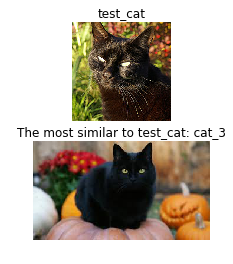


test_dog:

L1 for dog_features 1642.00
L1 for cat_features 3491.69


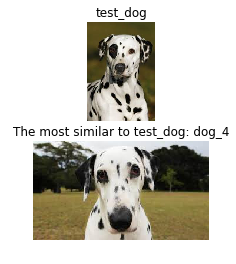

In [72]:
test_cat_features = sess.run(features, feed_dict={image_placeholder: test_cat})
test_cat_features = test_cat_features[0,0,0,:]
test_dog_features = sess.run(features, feed_dict={image_placeholder: test_dog})
test_dog_features = test_dog_features[0,0,0,:]

test_cat_dog_feat_L1 = np.sum(np.abs(dog_features_mat - np.tile(test_cat_features, (10, 1))), 1)
test_cat_cat_feat_L1 = np.sum(np.abs(cat_features_mat - np.tile(test_cat_features, (10, 1))), 1)

test_dog_dog_feat_L1 = np.sum(np.abs(dog_features_mat - np.tile(test_dog_features, (10, 1))), 1)
test_dog_cat_feat_L1 = np.sum(np.abs(cat_features_mat - np.tile(test_dog_features, (10, 1))), 1)

print('test_cat:\n')
print('L1 for dog_features %0.2f' % np.min(test_cat_dog_feat_L1))
print('L1 for cat_features %0.2f' % np.min(test_cat_cat_feat_L1))
minIndCat = str(np.argmin(test_cat_cat_feat_L1))
test_cat_sim_cat = mpimg.imread(os.path.join('..', 'Data', 'cats', 'cat_' + minIndCat + '.jpg'))
plt.figure()
plt.subplot(212); plt.imshow(test_cat_sim_cat); plt.axis('off'); plt.title('The most similar to test_cat: cat_' + minIndCat)
plt.subplot(211); plt.imshow(test_cat); plt.axis('off'); plt.title('test_cat')
plt.show()

print('\ntest_dog:\n')
print('L1 for dog_features %0.2f' % np.min(test_dog_dog_feat_L1))
print('L1 for cat_features %0.2f' % np.min(test_dog_cat_feat_L1))
minIndDog = str(np.argmin(test_dog_dog_feat_L1))
test_dog_sim_dog = mpimg.imread(os.path.join('..', 'Data', 'dogs', 'dog_' + minIndDog + '.jpg'))
plt.figure()
plt.subplot(212); plt.imshow(test_dog_sim_dog); plt.axis('off'); plt.title('The most similar to test_dog: dog_' + minIndDog)
plt.subplot(211); plt.imshow(test_dog); plt.axis('off'); plt.title('test_dog')
plt.show()

In [73]:
tiger = mpimg.imread(os.path.join('..', 'Data', 'tiger.jpg'))
wolf = mpimg.imread(os.path.join('..', 'Data', 'wolf.jpg'))

tiger:

L1 for dog_features 2662.12
L1 for cat_features 1959.98


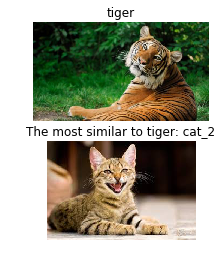


wolf:

L1 for dog_features 2060.38
L1 for cat_features 2232.22


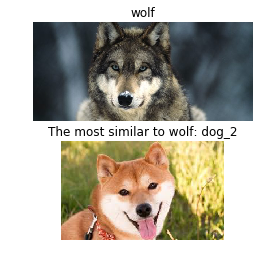

In [74]:
tiger_features = sess.run(features, feed_dict={image_placeholder: tiger})
tiger_features = tiger_features[0,0,0,:]
wolf_features = sess.run(features, feed_dict={image_placeholder: wolf})
wolf_features = wolf_features[0,0,0,:]

tiger_dog_feat_L1 = np.sum(np.abs(dog_features_mat - np.tile(tiger_features, (10, 1))), 1)
tiger_cat_feat_L1 = np.sum(np.abs(cat_features_mat - np.tile(tiger_features, (10, 1))), 1)

wolf_dog_feat_L1 = np.sum(np.abs(dog_features_mat - np.tile(wolf_features, (10, 1))), 1)
wolf_cat_feat_L1 = np.sum(np.abs(cat_features_mat - np.tile(wolf_features, (10, 1))), 1)

print('tiger:\n')
print('L1 for dog_features %0.2f' % np.min(tiger_dog_feat_L1))
print('L1 for cat_features %0.2f' % np.min(tiger_cat_feat_L1))
minIndCat = str(np.argmin(tiger_cat_feat_L1))
tiger_sim_cat = mpimg.imread(os.path.join('..', 'Data', 'cats', 'cat_' + minIndCat + '.jpg'))
plt.figure()
plt.subplot(212); plt.imshow(tiger_sim_cat); plt.axis('off'); plt.title('The most similar to tiger: cat_' + minIndCat)
plt.subplot(211); plt.imshow(tiger); plt.axis('off'); plt.title('tiger')
plt.show()

print('\nwolf:\n')
print('L1 for dog_features %0.2f' % np.min(wolf_dog_feat_L1))
print('L1 for cat_features %0.2f' % np.min(wolf_cat_feat_L1))
minIndDog = str(np.argmin(wolf_dog_feat_L1))
wolf_sim_dog = mpimg.imread(os.path.join('..', 'Data', 'dogs', 'dog_' + minIndDog + '.jpg'))
plt.figure()
plt.subplot(212); plt.imshow(wolf_sim_dog); plt.axis('off'); plt.title('The most similar to wolf: dog_' + minIndDog)
plt.subplot(211); plt.imshow(wolf); plt.axis('off'); plt.title('wolf')
plt.show()